<a href="https://colab.research.google.com/github/cdong22ucla/lab0113/blob/main/0224lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Pick your ticker and time period
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [3]:
# training data
x_train = []
y_train = []

#Pick your input size and edit to make binary forecast

input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
# testing data
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
# Build Your RNN Architecture

model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6448/6448 [==============================] - 49s 6ms/step - loss: 0.1422
Epoch 2/3
6448/6448 [==============================] - 36s 6ms/step - loss: 0.1326
Epoch 3/3
6448/6448 [==============================] - 38s 6ms/step - loss: 0.1287


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [6]:
def accuracy(actual, pred):
  pred = pred.ravel()
  acc = 0
  for i in range(len(actual)):
    if pred[i]>0 and actual[i]>0:
      acc += 1
    if pred[i]<0 and actual[i]<0:
      acc += 1
    else:
      acc += 0
  return acc/len(actual)

In [7]:
# in sample accuracy
train_predictions = model.predict(x_train)
in_sample_accuracy = accuracy(y_train, train_predictions)
in_sample_rmse = np.sqrt(np.mean(train_predictions - y_train)**2)
print('In sample accuracy:', in_sample_accuracy)
print('In sample RMSE:', in_sample_rmse)

202/202 [==============================] - 2s 3ms/step
In sample accuracy: 0.43641439205955335
In sample RMSE: 0.028766328309664944


In [8]:
# ouf of sample accuracy
test_predictions = model.predict(x_test)
out_sample_accuracy = accuracy(y_test, test_predictions)
out_samplermse = np.sqrt(np.mean(test_predictions - y_test)**2)
print('Out of sample accuracy:', out_sample_accuracy)
print('Out of sample RMSE:', out_samplermse)

51/51 [==============================] - 0s 5ms/step
Out of sample accuracy: 0.463112213267204
Out of sample RMSE: 0.00016881499855970092


In [9]:
# in sample random walk model
actual_in_sample_rw = y_train[1:] # actual
pred_in_sample_rw = y_train[:-1] # prediction
insample_rw_accuracy = accuracy(actual_in_sample_rw, pred_in_sample_rw)
in_rw_rmse = np.sqrt(np.mean(pred_in_sample_rw - actual_in_sample_rw)**2)
print('In sample random walk model accuracy:', insample_rw_accuracy)
print('In sample random walk model RMSE:', in_rw_rmse)

In sample random walk model accuracy: 0.36931906313013807
In sample random walk model RMSE: 0.00011952180274476443


In [10]:
# out of sample random walk model
actual_out_sample_rw = y_test[1:] # actual
pred_out_sample_rw = y_test[:-1] # prediction
outsample_rw_accuracy = accuracy(actual_out_sample_rw, pred_out_sample_rw)
out_rw_rmse = np.sqrt(np.mean(pred_out_sample_rw - actual_out_sample_rw)**2)
print('Out of sample random walk model accuracy:', outsample_rw_accuracy)
print('Out of sample random walk model RMSE:', out_rw_rmse)

Out of sample random walk model accuracy: 0.37344913151364767
Out of sample random walk model RMSE: 4.854894470254654e-05


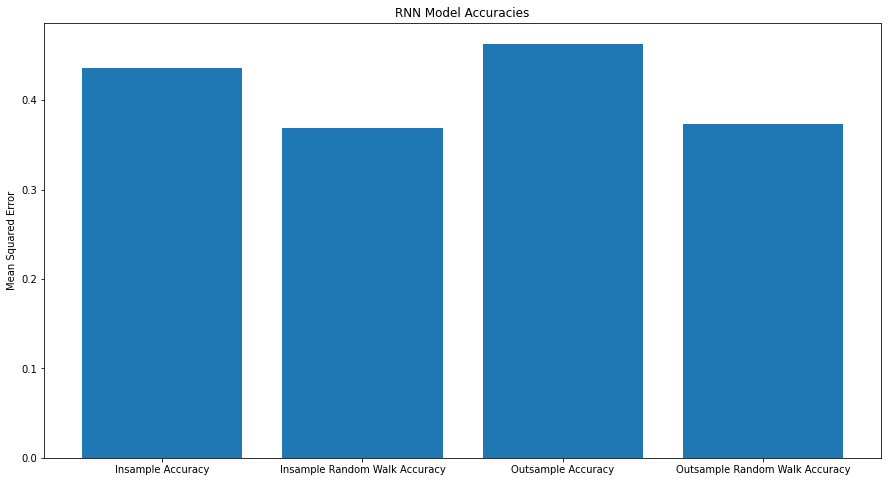

In [11]:
# bar chart
import matplotlib.pyplot as plt

labels = ['Insample Accuracy', 'Insample Random Walk Accuracy', 'Outsample Accuracy', 'Outsample Random Walk Accuracy']
accuracies = [in_sample_accuracy, insample_rw_accuracy, out_sample_accuracy, outsample_rw_accuracy]

plt.figure(figsize=(15,8))
plt.bar(labels, accuracies)
plt.title('RNN Model Accuracies')
plt.ylabel('Mean Squared Error')
plt.show()

# 4.) Plot in and out of sample accuracy

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

## Q3 observation:

From the results of Question 3, the out-of-sample model has the highest accuracy and the in-sample random walk model has the lowest accuracy. 

Also, compared with in-sample accuracy, out-of-sample accuracy is higher. 

Besides, the random walk models have lower accuracy compared to the corresponding common models.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast